In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
45,4.8,3.0,1.4,0.3,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
78,6.0,2.9,4.5,1.5,Iris-versicolor
7,5.0,3.4,1.5,0.2,Iris-setosa
46,5.1,3.8,1.6,0.2,Iris-setosa
...,...,...,...,...,...
18,5.7,3.8,1.7,0.3,Iris-setosa
129,7.2,3.0,5.8,1.6,Iris-virginica
112,6.8,3.0,5.5,2.1,Iris-virginica
15,5.7,4.4,1.5,0.4,Iris-setosa


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-virginica']. Probabilities: [[0. 0. 1.]]


### Use LIME to explain prediction

,sepal_length,sepal_width,petal_length,petal_width,label
116,6.5,3.0,5.5,1.8,Iris-virginica


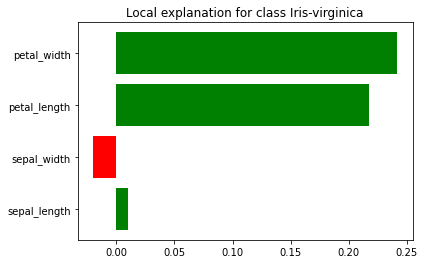

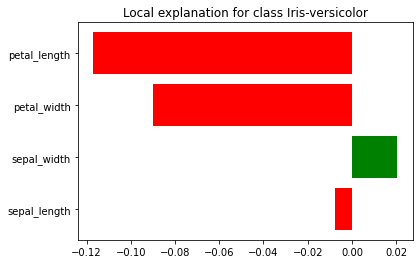

In [4]:
importlib.reload(lime.lime_tabular_mod)
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels,
    discretize_continuous=False,

)
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)
iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ]

In [5]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model(order="ordered"))
print(explanation.get_prediction_for_surrogate_model(normalized=True, order="ordered"))
print(explanation.get_scores_for_surrogate_model(order="ordered"))
print(explanation.get_losses_for_surrogate_model(order="ordered"))
print(explanation.get_fidelity_loss_on_explanation())
print(explanation.get_fidelity_loss_on_generated_data())


[0. 0. 1.]
[-0.017182177061740772, 0.38954968808153495, 0.6276324889802056]
[0.22688418 0.34075765 0.43235817]
[0.41850917610963834, 0.1448808973526039, 0.6507174326857958]
[0.046817278472874986, 0.13018356105532003, 0.04688264619350914]
0.16326982044758412
0.07939487253774362


In [6]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(3, 0.2420347177056656),
 (2, 0.2173909409396627),
 (1, -0.020123029450489355),
 (0, 0.0096965904751246)]

In [7]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, -0.11712716034060815),
 (3, -0.09012645541597657),
 (1, 0.020600413522667855),
 (0, -0.007578557953247329)]

In [8]:
explanation.as_map()

{0: [(3, -0.15190826228968907),
  (2, -0.10026378059905458),
  (0, -0.0021180325218772794),
  (1, -0.00047738407217851004)],
 1: [(2, -0.11712716034060815),
  (3, -0.09012645541597657),
  (1, 0.020600413522667855),
  (0, -0.007578557953247329)],
 2: [(3, 0.2420347177056656),
  (2, 0.2173909409396627),
  (1, -0.020123029450489355),
  (0, 0.0096965904751246)]}

In [9]:
explainer.discretizer.names

AttributeError: 'NoneType' object has no attribute 'names'

In [ ]:
explainer.discretizer.maxs
